# Model Evaluation

## 5.1 Cross-validation

**k-fold cross-validation**: Instead of having only one set of train/test, we have several cuts in the data split differently to compute the average test score. (usually between 5 - 10)

Looking at the range of scores in the folds gives us an idea on how well the model will be able to generalise to knew data. To summarise the performance of the model, we use the mean.

**Stratified k-fold cross-validation** is used by default in classification in scikit-learn. This means it considers how your data is split and follows this split in the generated train and test sets. For example, if your data has 90% label A and 10% label B, in each fold you have 90% label A samples and 10% label B samples. 

**IMPORTANT** Cross-validation is not a way to create a model that will be able to predict on new data. It only gives you information on how well a given algorithm will generalise on a specific dataset. The cross validation does not return a model.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()

logreg = LogisticRegression(max_iter=100000)

scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
#by default it produces 5 folds, but we can change the CV parameter

print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation: {scores.mean():.3f}")

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]
Mean cross-validation: 0.973


The CV parameter can be fine-adjusted. Let's say that instead of using the default stratified K-fold, you wanted to reproduce some results, and go with the k-fold instead. You can do that by adjusting the CV parameter as below:

In [13]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3)
print(f"Cross-validation scores: {cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")
# we will get a score of 0 0 0 because the data is ordered in way that the first points all belong to the same class


# another strategy instead of using stratified k-fold is to produce a suffling of the data
# but then remember to use random_state in order to get reproducible results
kfold_shuffle = KFold(n_splits=3, shuffle=True, random_state=0)
print(f"Cross-validation scores with shuffling: {cross_val_score(logreg, iris.data, iris.target, cv=kfold_shuffle)}")

Cross-validation scores: [0. 0. 0.]
Cross-validation scores with shuffling: [0.98 0.96 0.96]


**Leave-one-out cross-validation** is like a k-fold, but each fold is a single sample. It is not used very much because it is time-consuming, but it can be useful in small datasets.

In [14]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)

print(f"Number of cv iterations: {len(scores)}")
print(f"Mean accuracy: {scores.mean():.2f}")

Number of cv iterations: 150
Mean accuracy: 0.97


**Shuffle-split cross-validation**: In this form, you specify _train_size_ and _test_size_ samples to run _n_iter times_.
If you use integers, it uses the absolute number of samples, if you use float, it uses fractions of the whole dataset).
There is a stratified version of it, called **StratifiedShuffleSplit**  for more reliable results in categorisation problems.

In [15]:
from sklearn.model_selection import  ShuffleSplit

sf = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=sf)

print(f"Cross-validation scores {scores}")

Cross-validation scores [0.97333333 0.97333333 0.96       0.97333333 0.97333333 0.94666667
 0.96       0.94666667 0.96       0.93333333]


**Cross-validation with groups** in this type, you speficy groups so that when a fold is created, all itens inside the fold will be from that group. This is useful in applications where you have several data from the same person, for example, many medical recordings from groups of patients, voice recording, etc. 

In [22]:
from sklearn.model_selection import GroupKFold
from sklearn.datasets import make_blobs

# create synthetic dataset for this example
X, y = make_blobs(n_samples=12, random_state=0)

# assume the first three samples belong to the same group, then the next 4, etc...
groups = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]

scores = cross_val_score(logreg, X, y, cv=GroupKFold(n_splits=3), groups=groups)

print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.5        0.66666667 1.        ]


## 5.2 Grid Search

**NOTES**
- It is good to try extreme values for the grid at first and visualise the results in a heatmap or similar, to later fine tune to a grid that makes more sense. 
- If you see that the best score is on the edge of a heatmap visualisation, it might mean that there are even better values beyond the scope of what you tried. 

Grid search is a way to tune paramaters. Let's suppose a model has parameters A & B. You want to try the values 1,2, 3, 4 for A and B 4, 3, 5 for B. You have then 12 combinations. 


### 5.2.1 Simple Grid Search
You can implement a simple loop, like the example below:


In [34]:
# Simple Grid Search implementation

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

print(f"Size of the training set: {X_train.shape} \n Size of the test set: {X_test.shape}")

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train the SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)

        #evaluate on the test set
        score = svm.score(X_test, y_test)

        print(f"Gamma = {gamma} | C = {C} ||| Score = {score}")

        if score > best_score:
            best_score = score
            best_parameters = {'C': C, "Gamma": gamma}

print(f"\n BEST SCORE: {best_score:.2f}")
print(f"BEST PARAMETERS: {best_parameters}")

Size of the training set: (112, 4) 
 Size of the test set: (38, 4)
Gamma = 0.001 | C = 0.001 ||| Score = 0.23684210526315788
Gamma = 0.001 | C = 0.01 ||| Score = 0.23684210526315788
Gamma = 0.001 | C = 0.1 ||| Score = 0.23684210526315788
Gamma = 0.001 | C = 1 ||| Score = 0.5789473684210527
Gamma = 0.001 | C = 10 ||| Score = 0.9210526315789473
Gamma = 0.001 | C = 100 ||| Score = 0.9736842105263158
Gamma = 0.01 | C = 0.001 ||| Score = 0.23684210526315788
Gamma = 0.01 | C = 0.01 ||| Score = 0.23684210526315788
Gamma = 0.01 | C = 0.1 ||| Score = 0.5789473684210527
Gamma = 0.01 | C = 1 ||| Score = 0.9210526315789473
Gamma = 0.01 | C = 10 ||| Score = 0.9736842105263158
Gamma = 0.01 | C = 100 ||| Score = 0.9736842105263158
Gamma = 0.1 | C = 0.001 ||| Score = 0.23684210526315788
Gamma = 0.1 | C = 0.01 ||| Score = 0.23684210526315788
Gamma = 0.1 | C = 0.1 ||| Score = 0.9210526315789473
Gamma = 0.1 | C = 1 ||| Score = 0.9736842105263158
Gamma = 0.1 | C = 10 ||| Score = 0.9736842105263158
Gamma =

The risk of doing so that we overfit, since we are using information from out test set to inform our decision. **We should never use the test set to decide on the model settings**. Therefore, we create an extra set, called **validation test** to inform the parameter decision, and afterwards use both the training and validation sets to train our model.

In [41]:

# split data into train + validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_trainval, y_trainval, random_state=1)

print(f"Size of training set: {X_train.shape[0]} \n Size of validation set: {X_validation.shape[0]}")
print(f"Size of test set: {X_test.shape[0]}")

best_score = 0


for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svc = SVC(gamma=gamma, C=C)
        svc.fit(X_train, y_train)

        #evaluate the SVC using the validation score
        score = svc.score(X_validation, y_validation)

        if score > best_score:
            best_score = score
            best_parameters = {"gamma": gamma, "C": C}

# rebuild a model on the combined training and validation set, and evaluate on the test set
svc = SVC(**best_parameters)
svc.fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)

print(f"\n\nBest score on validation set: {score:.2f} \nBest parameters {best_parameters}")
print(f"Test score with best parameters: {test_score:.2f}")

Size of training set: 84 
 Size of validation set: 28
Size of test set: 38


Best score on validation set: 0.64 
Best parameters {'gamma': 0.001, 'C': 10}
Test score with best parameters: 0.92


### 5.2.2 Grid Search with Cross-Validation



Best score on validation set: 0.58 
Best parameters {'gamma': 0.1, 'C': 10}
Test score with best parameters: 0.97


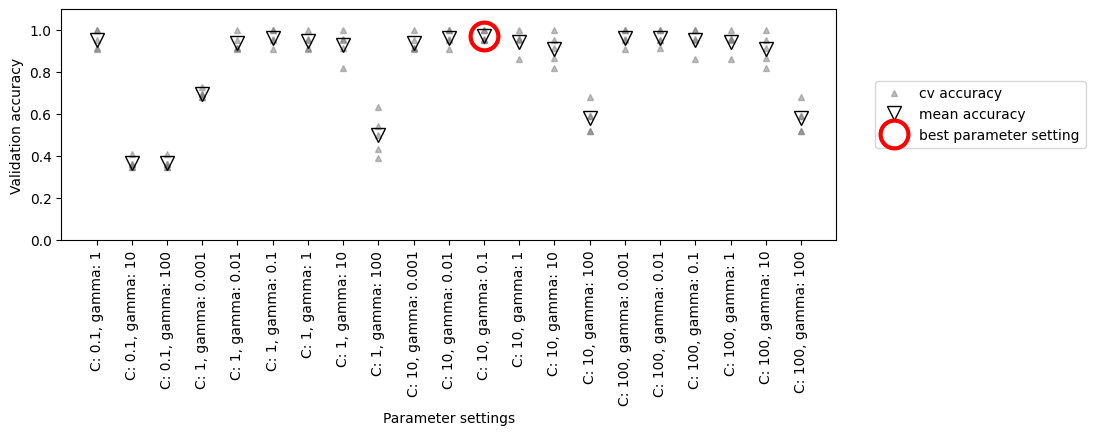

In [51]:
import numpy as np
import mglearn

gammas = [0.001, 0.01, 0.1, 1, 10, 100]
Cs = [0.001, 0.01, 0.1, 1, 10, 100]

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC

        svc = SVC(gamma=gamma, C=C)

        # perform cross-validation
        scores = cross_val_score(svc, X_trainval, y_trainval, cv=5)
        #compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score the parameters
        if score > best_score:
            best_score = score
            best_parameters = {"gamma":gamma, "C": C}

#rebuild the model on the combined training and validation set
svc = SVC(**best_parameters)
svc = svc.fit(X_trainval, y_trainval)
test_score = svc.score(X_test, y_test)


print(f"\n\nBest score on validation set: {score:.2f} \nBest parameters {best_parameters}")
print(f"Test score with best parameters: {test_score:.2f}")


mglearn.plots.plot_cross_val_selection()

Because the grid search with cross-validation is so popular, there is a class in SkLearn that implements the steps above, fitting the model for us. To be able to use it, you need to provide a dictionary in which the keys are the names of the parameters we want to adjust and their respective values.

The GridSearchCV returns an object in which you can use all the standard methods: fit, score, predict.
However, we still need to split the dataset into test and train to avoid overfitting.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# the lists are above t make it easier to read
parameter_grid = { "C": Cs, "gamma": gammas}

grid_search = GridSearchCV(SVC(), parameter_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

grid_search.fit(X_train, y_train)

print(f"Test score: {grid_search.score(X_test, y_test):.2f}")

# The best parameters are stored at best_params_ attribute
# The best cross-validation mean score is stored at best_score_

print(f"Best parameters {grid_search.best_params_}")
print(f"Best scores {grid_search.best_score_}")

# you can also access the the model with the best trained parameters using best_estimator_ attribute
# sometimes it is useful to look at it, and intepret coefficients

print(f"Best estimator {grid_search.best_estimator_}")

Test score: 0.97
Best parameters {'C': 10, 'gamma': 0.1}
Best scores 0.9731225296442687
Best estimator SVC(C=10, gamma=0.1)


Grid search is quite computationally expensive, so it might be better to start with a small grid of values, and then expdand it depending to the results. You can actually get details for the computation using the attribute *cv_results_*.
This is table is quite extensive, so it is better to visualise it with as a dataframe

In [56]:
import pandas as pd

#convert to DF
results = pd.DataFrame(grid_search.cv_results_)

display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001322,0.000432,0.001087,0.000599,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001446,0.000444,0.000909,0.000284,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001129,0.000172,0.000807,0.000217,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.001514,0.000469,0.000861,0.000190,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000941,0.000056,0.000602,0.000027,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


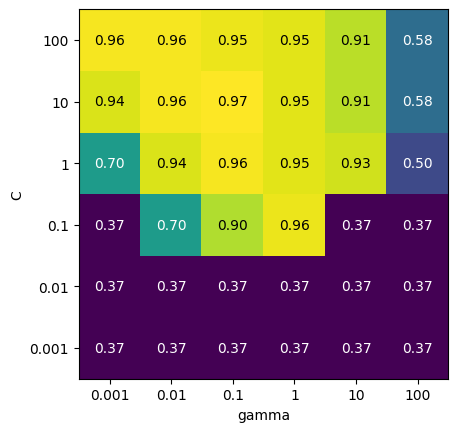

In [58]:
# the results are better visualised with a heatmap, since we are looking at a two-dimensional grid: Parameters (C and gamma)

scores = np.array(results.mean_test_score).reshape(6, -6)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=parameter_grid['gamma'],
ylabel='C', yticklabels=parameter_grid['C'], cmap="viridis")



**SEARCH OVER SPACES THAT ARE NOT GRID**

We can also use GridSearch to search further for other models, we just need to specificy the parameter_grid as a list of dictionaries. For example, the SVC has  kernel parameter, that we can use to test even further, such as the example below shows:

In [65]:
parameter_grid = [
  {"kernel": ["rbf"],
  "C": Cs,
  "gamma": gammas},

  {"kernel": ["linear"],
  "C": Cs #we dont'need to specify gamma because this model doesn't use it 
  },
]


grid_search = GridSearchCV(SVC(), parameter_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
print(f"Best estimator {grid_search.best_estimator_}")

print(f"Test score: {grid_search.score(X_test, y_test):.2f}")


results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T) #in the results, the gamma doesn't change when kernel is linear, because the model doesn't use it

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97
Best estimator SVC(C=10, gamma=0.1)
Test score: 0.97


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.002027,0.001754,0.002018,0.001536,0.001783,0.00364,0.001575,0.001253,0.001229,0.001368,...,0.000641,0.000719,0.00107,0.001045,0.000888,0.000764,0.000707,0.000663,0.000645,0.000659
std_fit_time,0.000478,0.000567,0.0007,0.000385,0.000642,0.001512,0.000644,0.000289,0.000472,0.000612,...,0.000052,0.000043,0.000074,0.000019,0.000075,0.000023,0.000064,0.000019,0.00001,0.000022
mean_score_time,0.001424,0.001422,0.001002,0.000963,0.003274,0.002174,0.001042,0.000921,0.000696,0.000852,...,0.000522,0.000482,0.000556,0.000638,0.000497,0.000489,0.00052,0.000465,0.00046,0.000474
std_score_time,0.000405,0.000449,0.000184,0.000233,0.00457,0.000981,0.000397,0.000281,0.000108,0.00014,...,0.000074,0.000004,0.000004,0.000114,0.000005,0.000003,0.000053,0.000002,0.0,0.000018
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


##  5.3 Evaluation Metrics and Scoring

In real life, most datasets are imbalanced. If you have 100 data points, and 90% are flagged 'green', but you want to create a model to identify 'red' points, if you have no model, you can just guess that a point will be green. in 90% of the cases you will be right. Therefore, the 'score' metric is not always the best, and not the only way to idenfify if your model is performing well. As a rule of thumb, is always depends on your business goal.

NOTE:
 - You can change the precision of the model, with the function decision_function.
 For classification, for example, the threshold is set at .5 (The model will predict a point as positive, if .5 or more certain that it belongs to a class.) If it is important that more points are positive, for example, you could decrease the threshold to .4 for example.

 *y_pred_lower_threshold = svc.decision_function(X_test) > -.8*

### Confusion Matrix

In [73]:
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print(f"Test score: {tree.score(X_test, y_test):.2f}")

# Generate a confusion matrix
# the confusion matrix goes: True negative, False positive \\ False negative, True negative
# the diagonal of the matrix has the correctly classified values

confusion = confusion_matrix(y_test, pred_tree)
print(f"Confusion matrix: \n{confusion}")

print(f"F1-Score: {f1_score(y_test, pred_tree):.2f}")
# here we will see that the tree model has a pretty bad f1-score, although its score was quite high
# that is why we should look into all these metrics in combination


Test score: 0.92
Confusion matrix: 
[[390  13]
 [ 24  23]]
F1-Score: 0.55


**PRECISION** How many of the positive samples are actually positive = *TP / (TP +FP)*
It is used when the goal is to limit the number of false positives.

**RECALL** How many of the positive samples are captured by the positive predictions = *TP / (TP + FN)*
It is used when we need to identify all positive samples, when it is important to avoid false negatives (like in cancer detection). 
Also called: sensitiviy, hit rate, true positive rate

**F-score** a more accurate way to look at precision & recall. You need to have a balance in most cases.
*F = 2 * (precision * recall) / (precision + recall)*


In [74]:
# if we want a more comprehensive summary of precision, recall and f-score, we can use the classification_report

from sklearn.metrics import classification_report

print(classification_report(y_test, pred_tree,
target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.94      0.97      0.95       403
        nine       0.64      0.49      0.55        47

    accuracy                           0.92       450
   macro avg       0.79      0.73      0.75       450
weighted avg       0.91      0.92      0.91       450



### Precision-recall curves

The precision_recall_curve function returns a list of precision and recall values for all possible thresholds. The more the curve stays on the top, the better the model. We need to find a middle point that is balance between precision and recall. In practice this can be done with the function *average_precision_score*.

F1 score: 0.81
Average precision score: 0.90


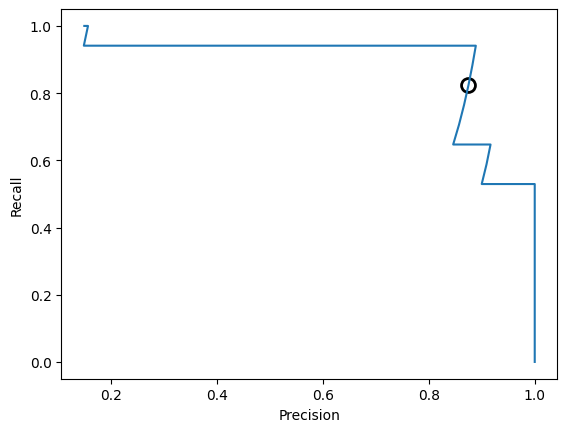

In [87]:
from sklearn.metrics import precision_recall_curve, average_precision_score
%matplotlib inline
import matplotlib.pyplot as plt

# NOTE: Tree models do no have the decision_function so we adapt it as below, with predic_proba
# precision, recall, tresholds = precision_recall_curve(y_test, tree.predic_proba(X_test)[:,1])

# First we will create a SVC model to ilustrate
from mglearn.datasets import make_blobs

# Use more data points for a smoother curve
X, y = make_blobs(n_samples=(400, 50), centers=[[0, 0], [10, 10]] , cluster_std=[7.0, 2],
random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")


print(f"F1 score: {f1_score(y_test, svc.predict(X_test)):.2f}")
print(f"Average precision score: {average_precision_score(y_test, svc.decision_function(X_test)):.2f}")


### ROC Curves (Receiver operating characteristics)